## MICROGRAD

In [110]:
#imports
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

import torch

import random


In [111]:
def f(x):
    return 3* x **2 - 4 * x + 5

In [112]:
f(3.0)

20.0

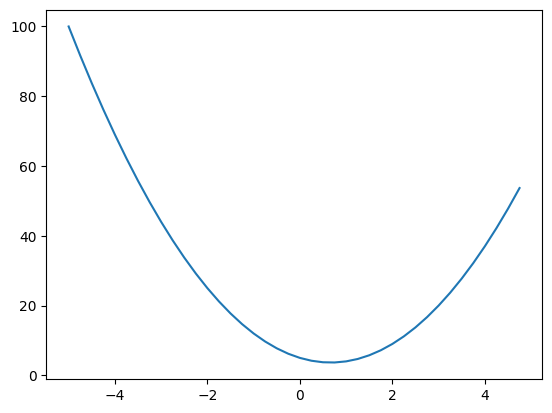

In [113]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [114]:
#derivatives measure the slope at a single point

#find the slope of f(x) with arbitrary small num 'h'
h = 0.00000001
x = -3.0
(f(x + h) - f(x))/h

-22.00000039920269

In [115]:
#more complex example
a = 2.0
b = -3.0
c = 10
d = a * b + c
print(d)

4.0


In [116]:
#testing how d changes when a, b and c are bumped slightly
h = 0.00001

a = 2.0
b = -3.0
c = 10

d1 = a * b + c

c += h

d2 = a * b + c

print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2 - d1)/h)


d1:  4.0
d2:  4.00001
slope:  0.9999999999621422


In [117]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out =  Value(t, (self,), label='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [118]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [119]:
d._op

'+'

In [120]:
def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name= uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

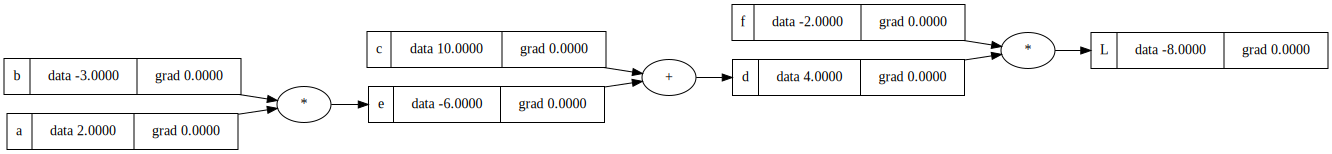

In [121]:
draw_dot(L)

In [122]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735, label='b')

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1) ; o.label = 'o'


In [123]:
#manual backpropagation
o.grad = 1.0
n.grad = 0.5    #1 - o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * 0.5
w2.grad = x2.data * 0.5
x1.grad = w1.data * 0.5
w1.grad = x1.data * 0.5

In [124]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [125]:
o.backward()

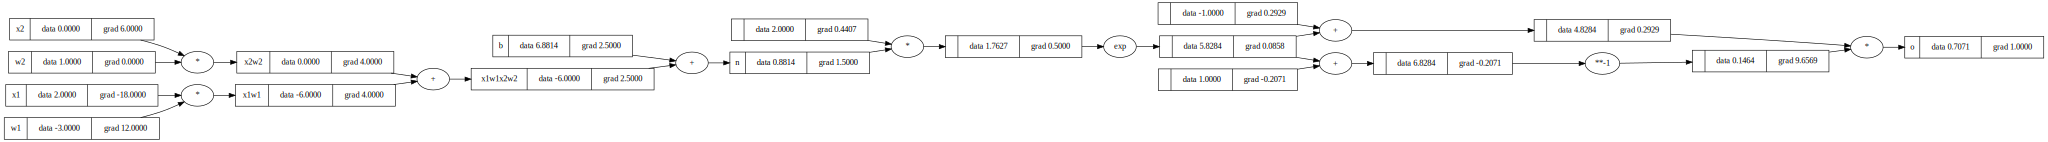

In [126]:
draw_dot(o)

In [127]:
xx1 = torch.Tensor([2.0]).double() ; xx1.requires_grad = True
xx2 = torch.Tensor([0.0]).double() ; xx2.requires_grad = True
ww1 = torch.Tensor([-3.0]).double() ; ww1.requires_grad = True
ww2 = torch.Tensor([1.0]).double() ; ww2.requires_grad = True
bb = torch.Tensor([6.8813735]).double() ; bb.requires_grad = True

nn = xx1 * ww1 + xx2 * ww2 + bb

oo = torch.tanh(nn)

print(oo)

print(oo.data.item())
oo.backward()

print("-----")
print("xx1", xx1.grad.item())
print("xx2", xx2.grad.item())
print("ww1", ww1.grad.item())
print("ww2", ww2.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358
-----
xx1 -1.5000003851533106
xx2 0.5000001283844369
ww1 1.0000002567688737
ww2 0.0


In [128]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [129]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [130]:
class MLP:

    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [131]:
n = MLP(3, [4, 4, 1])


In [132]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [133]:
ypred = [n(x) for x in xs]
print(ypred)

[value(data=0.6721120281355256), value(data=-0.37043637221752385), value(data=0.6232442042051227), value(data=0.3104324089433373)]


In [134]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print(loss)

value(data=3.6142860926412412)


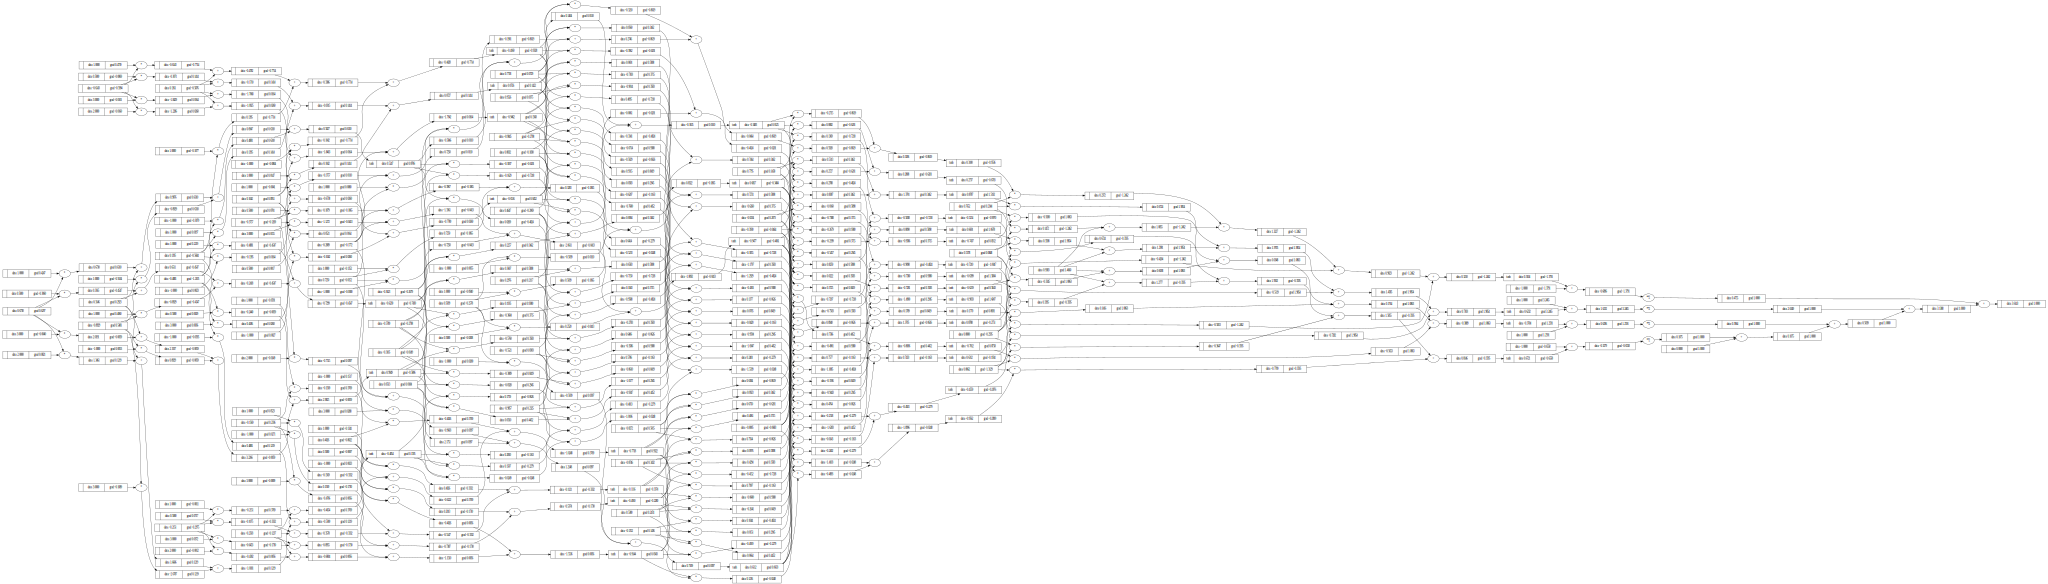

In [135]:
loss.backward()
draw_dot(loss)

In [136]:
n.parameters()

[value(data=0.6730328204337277),
 value(data=-0.8928987042049266),
 value(data=-0.4880537689283033),
 value(data=0.31455523634981186),
 value(data=-0.6142977980311615),
 value(data=0.13954661845033067),
 value(data=0.10417363469046004),
 value(data=0.1361280181408162),
 value(data=-0.2150870550476831),
 value(data=-0.15686122583332907),
 value(data=0.4026186632203552),
 value(data=-0.2502669376160478),
 value(data=-0.37573340710041747),
 value(data=0.7250483699186139),
 value(data=0.5039214945982056),
 value(data=-0.20887441980944566),
 value(data=-0.5789320292215872),
 value(data=0.9526081574564464),
 value(data=-0.87457879221409),
 value(data=-0.023438073964194617),
 value(data=0.2976272877282746),
 value(data=-0.3622871978349045),
 value(data=0.7718146899870466),
 value(data=-0.8271822221582683),
 value(data=0.7794816340867268),
 value(data=0.46470634745142303),
 value(data=-0.31051786122226255),
 value(data=-0.9844588420008127),
 value(data=0.5379917566413173),
 value(data=-0.39302

In [137]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [244]:
for _ in range(5):
    #forward pass
    ypred = [n(x) for x in xs]
    print(ypred, ys)

    #calculate loss
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    print(loss)

    #zero grad
    for p in n.parameters():
        p.grad = 0.0

    #backward pass
    loss.backward()

    #step
    for p in n.parameters():
        p.data += -0.01 * p.grad

[value(data=0.973253437601062), value(data=-0.9494894250723782), value(data=-0.944172299226201), value(data=0.9548710938319127)] [1.0, -1.0, -1.0, 1.0]
value(data=0.008420047125296037)
[value(data=0.9733205715912516), value(data=-0.9495986710339738), value(data=-0.9443076018537792), value(data=0.9549631107748375)] [1.0, -1.0, -1.0, 1.0]
value(data=0.008382050464115862)
[value(data=0.9733872279950849), value(data=-0.94970722943155), value(data=-0.9444419802801682), value(data=0.955054550137055)] [1.0, -1.0, -1.0, 1.0]
value(data=0.008344389423808067)
[value(data=0.9734534122923146), value(data=-0.9498151074101112), value(data=-0.9445754447705216), value(data=0.9551454179670525)] [1.0, -1.0, -1.0, 1.0]
value(data=0.008307059614916424)
[value(data=0.973519129876469), value(data=-0.9499223120113605), value(data=-0.9447080054328009), value(data=0.9552357202247997)] [1.0, -1.0, -1.0, 1.0]
value(data=0.008270056723798429)
